# PreTrain

In [1]:
from model.sswae_dev2_1 import SSWAE_HSIC_MNIST as cur_model

import os, sys, configparser, logging, argparse, time
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

from XAE.dataset import rmMNIST
from XAE.dataset import MNIST
from XAE.util import init_params

import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
y_dim = 7

d = 64
embed_data = nn.Sequential(
    nn.Conv2d(1, d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, 2*d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Conv2d(2*d, 2*d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Flatten(),
).to(device)

embed_condition = nn.Sequential(
    nn.Linear(49*2*d, d),
    nn.BatchNorm1d(d),
    nn.ReLU(True),
    
    nn.Linear(d, y_dim),
).to(device)

enc_activation = nn.Sequential(
    nn.BatchNorm1d(y_dim),
    nn.ReLU(True),
    nn.Linear(y_dim, 10),
).to(device)

init_params(embed_data)
init_params(embed_condition)
init_params(enc_activation)

In [3]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [4]:
def kk(x, y, diag = True):
    stat = 0.
    for scale in [.1, .2, .5, 1., 2., 5., 10.]:
        C = scale*2*y_dim*2
        kernel = (C/(C + (x.unsqueeze(0) - y.unsqueeze(1)).pow(2).sum(dim = 2)))
        if diag:
            stat += kernel.sum()
        else:
            stat += kernel.sum() - kernel.diag().sum()
    return stat

In [5]:
epoch = 20
opt = optim.Adam(list(embed_data.parameters()) + list(embed_condition.parameters()) + list(enc_activation.parameters()), lr = 1e-3, betas = (0.9, 0.999))
crit = nn.CrossEntropyLoss()
running_loss = 0.0

for k in range(epoch):
    for i, (data, condition) in enumerate(train_generator):
        opt.zero_grad()
        n = len(data)
        x = data.to(device)
        y = condition.to(device)
        
        xx = embed_condition(embed_data(x))
        output = enc_activation(xx)
        loss = crit(output, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (k + 1, running_loss / len(train_generator)))
    running_loss = 0.0

[1] loss: 1.429
[2] loss: 0.437
[3] loss: 0.280
[4] loss: 0.198
[5] loss: 0.078
[6] loss: 0.029
[7] loss: 0.015
[8] loss: 0.013
[9] loss: 0.010
[10] loss: 0.007
[11] loss: 0.007
[12] loss: 0.007
[13] loss: 0.006
[14] loss: 0.005
[15] loss: 0.005
[16] loss: 0.002
[17] loss: 0.005
[18] loss: 0.004
[19] loss: 0.004
[20] loss: 0.002


In [6]:
batch_size = 100
test_data = MNIST('./data/MNIST', train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

a, b = next(iter(test_generator))
embed_condition(embed_data(a.to(device))).shape

torch.Size([100, 7])

In [7]:
f1 = np.zeros((0, 10))
f2 = np.zeros((0, y_dim))

i = 0
for a, b in test_generator:
    f1x = b.to('cpu').detach().numpy()
    f2x = embed_condition(embed_data(a.to(device))).to('cpu').detach().numpy()
    f1 = np.concatenate((f1, f1x), axis = 0)
    f2 = np.concatenate((f2, f2x), axis = 0)
    i += 1
    if i == 5:
        break
        
digit = np.arange(10)
lab = [digit[l.astype(np.bool_)] for l in f1]
lab = np.concatenate(lab)

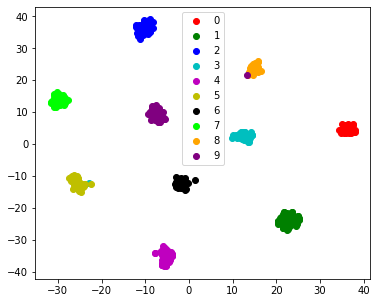

In [8]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(f2)

target_ids = list(range(10))

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(X_2d[lab == i, 0], X_2d[lab == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

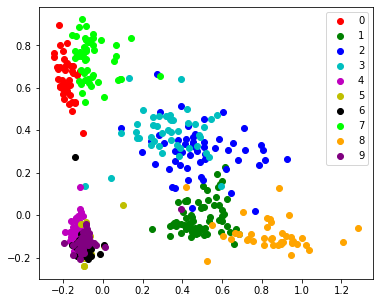

In [9]:
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(f2[lab == i, 0], f2[lab == i, 2], c=c, label=str(i))
plt.legend()
plt.show()

In [10]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0, class_no = True)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [11]:
ys = np.zeros((10, y_dim))
cs = np.zeros(10)
covs = np.zeros((10, y_dim, y_dim))

for data, condition in train_generator:
    n = len(data)
    x = data.to(device)
    y = condition.to(device)
    z = embed_condition(embed_data(x))
    labs, idxs, counts = y.unique(dim = 0, return_inverse = True, return_counts = True)
    idxs = labs[idxs].view(n,1).expand(-1, y_dim)
    cc = torch.zeros((10, y_dim), dtype = torch.float).to(device).scatter_add_(0, idxs, z)
    ys += cc.detach().to('cpu').numpy()
    cs += counts[labs].detach().to('cpu').numpy()
    
    for i in range(10):
        cov = torch.cov(z[y==i,:].T, correction=0) * torch.sum(y==i)
        covs[i,:,:] += cov.detach().to('cpu').numpy()

In [12]:
w1 = torch.Tensor(ys.transpose()/cs)
w1

tensor([[-0.1685,  0.4911,  0.4854,  0.3291, -0.1326, -0.0890, -0.1013, -0.0729,
          0.8618, -0.0980],
        [-0.2793,  0.1846,  0.3315, -0.1905,  0.4350, -0.2524,  0.1638, -0.0585,
         -0.2481, -0.2236],
        [ 0.5924, -0.0163,  0.2767,  0.3717, -0.0587, -0.1530, -0.1496,  0.7197,
         -0.1138, -0.1277],
        [-0.1696, -0.0908,  0.3124,  0.3236, -0.2048,  0.6404,  0.0830,  0.2896,
         -0.1162, -0.1054],
        [-0.1777,  0.4733,  0.1143, -0.1931, -0.1578, -0.1682, -0.1535,  0.4464,
         -0.1996,  0.4228],
        [ 0.5193, -0.0642,  0.6111, -0.1511, -0.1983,  0.0443,  0.3990, -0.1568,
         -0.0526, -0.1005],
        [ 0.1238,  0.4122, -0.0982,  0.4210, -0.1254, -0.0565,  0.3544, -0.0578,
         -0.1085, -0.0807]])

In [13]:
f1 = nn.Linear(10, y_dim, bias = False)
f1.weight.data = w1
torch.save(f1.state_dict(), f'./result/mu_{y_dim}.pt')

In [14]:
w2 = torch.tensor((covs.T / (cs - 1)).T)

In [15]:
for i in range(10):
    e, v = torch.symeig(w2[i,:,:], eigenvectors = True)
    w2[i,:,:] = v @ torch.diag(torch.sqrt(e)) @ v.T

In [16]:
f2 = nn.ConvTranspose2d(10, 1, y_dim, bias=False)
f2.weight.data = w2.view(10,1,y_dim,y_dim)
torch.save(f2.state_dict(), f'./result/cov_{y_dim}.pt')

# Train

In [5]:
from XAE.logging_daily import logging_daily

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

logger = logging_daily('./config/log_info.yaml')
log = logger.get_logging()
log.setLevel(logging.INFO)

cfg = configparser.ConfigParser()
cfg.read('./config/sswae_dev2_1_16.cfg')

['./config/sswae_dev2_1_16.cfg']

In [6]:
mm = cur_model(cfg, log, device = device)

mm.gm.mu.load_state_dict(torch.load(f'./result/mu_{mm.y_dim}.pt'))
mm.gm.cov.load_state_dict(torch.load(f'./result/cov_{mm.y_dim}.pt'))

mm.train()
# mm.load('./%s' % (cfg['path_info']['save_path']))

[default |INFO|_base_model.py:27] ------------------------------------------------------------
[default |INFO|_base_model.py:29] model_name : SSWAE_HSIC_MNIST
[default |INFO|_base_model.py:29] train_data : rmMNIST
[default |INFO|_base_model.py:29] train_data_label : True
[default |INFO|_base_model.py:29] z_sampler : gaus
[default |INFO|_base_model.py:29] z_dim : 5
[default |INFO|_base_model.py:29] y_sampler : gaus
[default |INFO|_base_model.py:29] y_dim : 7
[default |INFO|_base_model.py:29] labeled_class : 0,1,2,3,4,5,6,7,8,9
[default |INFO|_base_model.py:29] unlabeled_class : 
[default |INFO|_base_model.py:29] test_class : 
[default |INFO|_base_model.py:29] portion : 1.0
[default |INFO|_base_model.py:29] encoder_pretrain : False
[default |INFO|_base_model.py:29] encoder_pretrain_step : 3
[default |INFO|_base_model.py:29] lr : 5e-4
[default |INFO|_base_model.py:29] beta1 : 0.5
[default |INFO|_base_model.py:29] lr_adv : 2e-4
[default |INFO|_base_model.py:29] beta1_adv : 0.5
[default |IN

[default |INFO|model.py:1280] [01/80]  loss: 2.382579e-01  D: 6.908405e-01  D2: 3.884879e-02  D3: 2.182215e-03
test loss: 1.741497e-01  D: 6.900743e-01  D2: 1.131491e-02  D3: 6.020180e-03


[default |INFO|model.py:1280] [02/80]  loss: 1.652325e-01  D: 6.947300e-01  D2: 7.792382e-03  D3: 7.667042e-03
test loss: 1.610118e-01  D: 7.131634e-01  D2: 3.042650e-03  D3: 1.121931e-02


[default |INFO|model.py:1280] [03/80]  loss: 1.386630e-01  D: 6.936080e-01  D2: 9.993267e-04  D3: 8.019366e-03
test loss: 1.225603e-01  D: 6.709439e-01  D2: -3.569508e-04  D3: 6.099913e-03


[default |INFO|model.py:1280] [04/80]  loss: 1.183613e-01  D: 7.040841e-01  D2: -1.878074e-03  D3: 1.092040e-02
test loss: 1.080315e-01  D: 6.936093e-01  D2: -2.953997e-03  D3: 9.127237e-03


[default |INFO|model.py:1280] [05/80]  loss: 9.618363e-02  D: 6.958391e-01  D2: -3.819922e-03  D3: 9.548635e-03
test loss: 8.992651e-02  D: 6.644670e-01  D2: -3.395844e-03  D3: 1.099608e-02


[default |INFO|model.py:1280] [06/80]  loss: 9.061040e-02  D: 6.930979e-01  D2: -4.132751e-03  D3: 1.139764e-02
test loss: 8.957833e-02  D: 6.917941e-01  D2: -3.886099e-03  D3: 1.581306e-02


[default |INFO|model.py:1280] [07/80]  loss: 8.938840e-02  D: 6.963112e-01  D2: -4.318763e-03  D3: 1.231360e-02
test loss: 1.005234e-01  D: 7.095100e-01  D2: -3.909893e-03  D3: 1.343362e-02


[default |INFO|model.py:1280] [08/80]  loss: 8.739125e-02  D: 6.924549e-01  D2: -4.531396e-03  D3: 1.485561e-02
test loss: 8.269608e-02  D: 6.971871e-01  D2: -4.463577e-03  D3: 1.516700e-02


[default |INFO|model.py:1280] [09/80]  loss: 7.886552e-02  D: 6.935614e-01  D2: -5.011878e-03  D3: 1.316965e-02
test loss: 7.242374e-02  D: 6.630073e-01  D2: -4.706726e-03  D3: 1.194283e-02


[default |INFO|model.py:1280] [10/80]  loss: 7.670170e-02  D: 6.933579e-01  D2: -5.125971e-03  D3: 1.368499e-02
test loss: 7.392137e-02  D: 6.632858e-01  D2: -5.545158e-03  D3: 1.001322e-02


[default |INFO|model.py:1280] [11/80]  loss: 8.075568e-02  D: 6.966028e-01  D2: -5.108789e-03  D3: 1.145446e-02
test loss: 7.892119e-02  D: 7.147540e-01  D2: -5.004225e-03  D3: 1.121828e-02


[default |INFO|model.py:1280] [12/80]  loss: 7.530554e-02  D: 6.939239e-01  D2: -5.587684e-03  D3: 1.307625e-02
test loss: 7.083388e-02  D: 7.131347e-01  D2: -6.193495e-03  D3: 1.473748e-02


[default |INFO|model.py:1280] [13/80]  loss: 7.707303e-02  D: 6.926035e-01  D2: -5.258640e-03  D3: 1.288887e-02
test loss: 7.183751e-02  D: 6.960288e-01  D2: -5.640764e-03  D3: 1.366223e-02


[default |INFO|model.py:1280] [14/80]  loss: 7.086803e-02  D: 6.935038e-01  D2: -5.613745e-03  D3: 1.324087e-02
test loss: 6.917592e-02  D: 6.863098e-01  D2: -5.694761e-03  D3: 1.056414e-02


[default |INFO|model.py:1280] [15/80]  loss: 6.928483e-02  D: 6.930408e-01  D2: -5.987012e-03  D3: 1.339758e-02
test loss: 6.618239e-02  D: 6.838522e-01  D2: -6.159248e-03  D3: 1.061008e-02


[default |INFO|model.py:1280] [16/80]  loss: 6.814470e-02  D: 6.947721e-01  D2: -5.773013e-03  D3: 1.318097e-02
test loss: 6.778765e-02  D: 6.925528e-01  D2: -5.769033e-03  D3: 1.514874e-02


[default |INFO|model.py:1280] [17/80]  loss: 6.720523e-02  D: 6.948449e-01  D2: -6.222769e-03  D3: 1.270941e-02
test loss: 6.662623e-02  D: 6.919942e-01  D2: -5.578136e-03  D3: 1.122215e-02


[default |INFO|model.py:1280] [18/80]  loss: 6.508525e-02  D: 6.946955e-01  D2: -6.145795e-03  D3: 1.330566e-02
test loss: 6.160066e-02  D: 6.907284e-01  D2: -6.296911e-03  D3: 9.869277e-03


[default |INFO|model.py:1280] [19/80]  loss: 6.528747e-02  D: 6.922724e-01  D2: -6.156839e-03  D3: 1.296683e-02
test loss: 6.415116e-02  D: 7.029363e-01  D2: -6.185102e-03  D3: 1.424491e-02


[default |INFO|model.py:1280] [20/80]  loss: 6.253012e-02  D: 6.945172e-01  D2: -6.536692e-03  D3: 1.332129e-02
test loss: 6.357294e-02  D: 6.886613e-01  D2: -6.400824e-03  D3: 1.175760e-02


[default |INFO|model.py:1280] [21/80]  loss: 6.205207e-02  D: 6.929478e-01  D2: -6.539679e-03  D3: 1.354867e-02
test loss: 5.877081e-02  D: 7.052545e-01  D2: -7.229195e-03  D3: 1.473440e-02


[default |INFO|model.py:1280] [22/80]  loss: 6.119598e-02  D: 6.944240e-01  D2: -6.682590e-03  D3: 1.340537e-02
test loss: 6.472235e-02  D: 6.853493e-01  D2: -6.245308e-03  D3: 1.555771e-02


[default |INFO|model.py:1280] [23/80]  loss: 6.244301e-02  D: 6.944484e-01  D2: -6.729898e-03  D3: 1.292540e-02
test loss: 5.896248e-02  D: 6.849384e-01  D2: -7.466707e-03  D3: 1.336840e-02


[default |INFO|model.py:1280] [24/80]  loss: 5.834070e-02  D: 6.934724e-01  D2: -6.903456e-03  D3: 1.346135e-02
test loss: 5.645902e-02  D: 6.976601e-01  D2: -7.398214e-03  D3: 1.387116e-02


[default |INFO|model.py:1280] [25/80]  loss: 5.737295e-02  D: 6.944796e-01  D2: -7.031438e-03  D3: 1.346439e-02
test loss: 6.019415e-02  D: 6.889138e-01  D2: -7.190895e-03  D3: 1.396307e-02


[default |INFO|model.py:1280] [26/80]  loss: 5.759797e-02  D: 6.920049e-01  D2: -7.227899e-03  D3: 1.318302e-02
test loss: 5.589128e-02  D: 6.993785e-01  D2: -6.821766e-03  D3: 1.190900e-02


[default |INFO|model.py:1280] [27/80]  loss: 5.625343e-02  D: 6.939094e-01  D2: -7.085732e-03  D3: 1.351455e-02
test loss: 5.499826e-02  D: 6.873872e-01  D2: -7.113609e-03  D3: 1.308205e-02


[default |INFO|model.py:1280] [28/80]  loss: 5.505704e-02  D: 6.939242e-01  D2: -7.161206e-03  D3: 1.349924e-02
test loss: 5.590243e-02  D: 6.845545e-01  D2: -7.389374e-03  D3: 1.200611e-02


[default |INFO|model.py:1280] [29/80]  loss: 5.605010e-02  D: 6.935212e-01  D2: -7.379106e-03  D3: 1.342808e-02
test loss: 5.798805e-02  D: 6.887880e-01  D2: -7.226238e-03  D3: 1.444809e-02


[default |INFO|model.py:1280] [30/80]  loss: 5.495200e-02  D: 6.946080e-01  D2: -7.272766e-03  D3: 1.350847e-02
test loss: 5.447423e-02  D: 7.099679e-01  D2: -7.768116e-03  D3: 1.365947e-02


[default |INFO|model.py:1280] [31/80]  loss: 5.403682e-02  D: 6.940472e-01  D2: -7.562466e-03  D3: 1.328801e-02
test loss: 5.535566e-02  D: 6.955315e-01  D2: -7.659502e-03  D3: 1.331977e-02


[default |INFO|model.py:1280] [32/80]  loss: 5.419818e-02  D: 6.942769e-01  D2: -7.587384e-03  D3: 1.351845e-02
test loss: 5.552274e-02  D: 6.728401e-01  D2: -7.838669e-03  D3: 1.420010e-02


[default |INFO|model.py:1280] [33/80]  loss: 5.339259e-02  D: 6.932889e-01  D2: -7.694035e-03  D3: 1.330016e-02
test loss: 5.362570e-02  D: 6.842529e-01  D2: -7.685528e-03  D3: 1.415796e-02


[default |INFO|model.py:1280] [34/80]  loss: 5.290209e-02  D: 6.935300e-01  D2: -7.805702e-03  D3: 1.332687e-02
test loss: 5.270864e-02  D: 6.913966e-01  D2: -7.584219e-03  D3: 1.264368e-02


[default |INFO|model.py:1280] [35/80]  loss: 5.277513e-02  D: 6.938820e-01  D2: -7.875080e-03  D3: 1.317906e-02
test loss: 5.399360e-02  D: 6.909672e-01  D2: -8.270102e-03  D3: 1.366221e-02


[default |INFO|model.py:1280] [36/80]  loss: 5.313787e-02  D: 6.937251e-01  D2: -7.917892e-03  D3: 1.310656e-02
test loss: 5.366028e-02  D: 6.857997e-01  D2: -8.059254e-03  D3: 1.354546e-02


[default |INFO|model.py:1280] [37/80]  loss: 5.260179e-02  D: 6.931110e-01  D2: -7.960312e-03  D3: 1.321550e-02
test loss: 5.357838e-02  D: 6.850491e-01  D2: -7.769098e-03  D3: 1.369314e-02


[default |INFO|model.py:1280] [38/80]  loss: 5.247157e-02  D: 6.938696e-01  D2: -8.017136e-03  D3: 1.318690e-02
test loss: 5.489404e-02  D: 6.953399e-01  D2: -8.082333e-03  D3: 1.502591e-02


[default |INFO|model.py:1280] [39/80]  loss: 5.190092e-02  D: 6.938335e-01  D2: -8.092232e-03  D3: 1.317534e-02
test loss: 5.178596e-02  D: 6.957481e-01  D2: -8.107319e-03  D3: 1.273513e-02


[default |INFO|model.py:1280] [40/80]  loss: 5.149486e-02  D: 6.932006e-01  D2: -8.307389e-03  D3: 1.322692e-02
test loss: 5.250125e-02  D: 6.943293e-01  D2: -8.616333e-03  D3: 1.220662e-02


[default |INFO|model.py:1280] [41/80]  loss: 5.194375e-02  D: 6.939979e-01  D2: -8.282541e-03  D3: 1.272701e-02
test loss: 5.325920e-02  D: 6.793376e-01  D2: -8.330412e-03  D3: 1.400014e-02


[default |INFO|model.py:1280] [42/80]  loss: 5.127254e-02  D: 6.929795e-01  D2: -8.331610e-03  D3: 1.318253e-02
test loss: 5.195181e-02  D: 6.999577e-01  D2: -8.189449e-03  D3: 1.283624e-02


[default |INFO|model.py:1280] [43/80]  loss: 5.143401e-02  D: 6.935035e-01  D2: -8.328902e-03  D3: 1.287623e-02
test loss: 5.302789e-02  D: 6.852391e-01  D2: -8.346472e-03  D3: 1.321541e-02


[default |INFO|model.py:1280] [44/80]  loss: 5.163712e-02  D: 6.935673e-01  D2: -8.511268e-03  D3: 1.298501e-02
test loss: 5.312851e-02  D: 7.047864e-01  D2: -8.680506e-03  D3: 1.481505e-02


[default |INFO|model.py:1280] [45/80]  loss: 5.071686e-02  D: 6.926889e-01  D2: -8.626394e-03  D3: 1.284774e-02
test loss: 5.159867e-02  D: 6.944150e-01  D2: -8.528852e-03  D3: 1.408504e-02


[default |INFO|model.py:1280] [46/80]  loss: 4.996759e-02  D: 6.933021e-01  D2: -8.555269e-03  D3: 1.307384e-02
test loss: 5.060799e-02  D: 6.891389e-01  D2: -8.508320e-03  D3: 1.260624e-02


[default |INFO|model.py:1280] [47/80]  loss: 4.982193e-02  D: 6.932950e-01  D2: -8.693194e-03  D3: 1.300667e-02
test loss: 5.181698e-02  D: 6.944016e-01  D2: -8.487358e-03  D3: 1.343287e-02


[default |INFO|model.py:1280] [48/80]  loss: 4.984773e-02  D: 6.933405e-01  D2: -8.737361e-03  D3: 1.300982e-02
test loss: 5.229251e-02  D: 6.883577e-01  D2: -8.641119e-03  D3: 1.215367e-02


[default |INFO|model.py:1280] [49/80]  loss: 5.033893e-02  D: 6.942442e-01  D2: -8.751822e-03  D3: 1.269052e-02
test loss: 5.213655e-02  D: 6.872439e-01  D2: -8.682833e-03  D3: 1.060020e-02


[default |INFO|model.py:1280] [50/80]  loss: 5.103240e-02  D: 6.934040e-01  D2: -8.802520e-03  D3: 1.247651e-02
test loss: 5.018297e-02  D: 7.012411e-01  D2: -8.798294e-03  D3: 1.171247e-02


[default |INFO|model.py:1280] [51/80]  loss: 4.939418e-02  D: 6.932385e-01  D2: -8.892086e-03  D3: 1.274076e-02
test loss: 5.085261e-02  D: 6.942724e-01  D2: -8.717756e-03  D3: 1.281508e-02


[default |INFO|model.py:1280] [52/80]  loss: 4.933166e-02  D: 6.936553e-01  D2: -8.918420e-03  D3: 1.268077e-02
test loss: 5.183189e-02  D: 6.874317e-01  D2: -9.027491e-03  D3: 1.310182e-02


[default |INFO|model.py:1280] [53/80]  loss: 4.906386e-02  D: 6.930564e-01  D2: -8.899585e-03  D3: 1.280837e-02
test loss: 5.102797e-02  D: 6.959246e-01  D2: -8.944168e-03  D3: 1.293524e-02


[default |INFO|model.py:1280] [54/80]  loss: 4.942673e-02  D: 6.937417e-01  D2: -8.988446e-03  D3: 1.256397e-02
test loss: 5.393287e-02  D: 6.948016e-01  D2: -8.954887e-03  D3: 1.373389e-02


[default |INFO|model.py:1280] [55/80]  loss: 4.959570e-02  D: 6.932305e-01  D2: -9.048041e-03  D3: 1.246998e-02
test loss: 5.191653e-02  D: 6.971159e-01  D2: -8.615799e-03  D3: 1.110170e-02


[default |INFO|model.py:1280] [56/80]  loss: 5.027266e-02  D: 6.932463e-01  D2: -9.067588e-03  D3: 1.210975e-02
test loss: 5.211073e-02  D: 7.046237e-01  D2: -8.663988e-03  D3: 1.286207e-02


[default |INFO|model.py:1280] [57/80]  loss: 4.902842e-02  D: 6.939583e-01  D2: -9.065499e-03  D3: 1.257900e-02
test loss: 5.115885e-02  D: 6.962363e-01  D2: -9.007797e-03  D3: 1.300588e-02


[default |INFO|model.py:1280] [58/80]  loss: 4.874979e-02  D: 6.937242e-01  D2: -9.189830e-03  D3: 1.249128e-02
test loss: 5.151289e-02  D: 6.882831e-01  D2: -9.075890e-03  D3: 1.309268e-02


[default |INFO|model.py:1280] [59/80]  loss: 4.940941e-02  D: 6.934986e-01  D2: -9.193106e-03  D3: 1.237115e-02
test loss: 5.208871e-02  D: 7.027172e-01  D2: -9.242973e-03  D3: 1.135238e-02


[default |INFO|model.py:1280] [60/80]  loss: 4.846127e-02  D: 6.933546e-01  D2: -9.297942e-03  D3: 1.236120e-02
test loss: 5.083576e-02  D: 7.045533e-01  D2: -9.349461e-03  D3: 1.199758e-02


[default |INFO|model.py:1280] [61/80]  loss: 4.965326e-02  D: 6.935903e-01  D2: -9.290854e-03  D3: 1.223673e-02
test loss: 5.142345e-02  D: 7.013358e-01  D2: -9.383221e-03  D3: 1.010583e-02


[default |INFO|model.py:1280] [62/80]  loss: 4.953167e-02  D: 6.932352e-01  D2: -9.316076e-03  D3: 1.217295e-02
test loss: 5.118916e-02  D: 6.768140e-01  D2: -9.124632e-03  D3: 1.315420e-02


[default |INFO|model.py:1280] [63/80]  loss: 4.868897e-02  D: 6.927262e-01  D2: -9.389299e-03  D3: 1.242355e-02
test loss: 5.011249e-02  D: 6.918569e-01  D2: -9.230061e-03  D3: 1.178958e-02


[default |INFO|model.py:1280] [64/80]  loss: 4.929414e-02  D: 6.921976e-01  D2: -9.377364e-03  D3: 1.201990e-02
test loss: 5.074391e-02  D: 6.837785e-01  D2: -9.294558e-03  D3: 1.073546e-02


[default |INFO|model.py:1280] [65/80]  loss: 4.872356e-02  D: 6.936982e-01  D2: -9.388404e-03  D3: 1.223593e-02
test loss: 5.115235e-02  D: 6.909895e-01  D2: -9.471397e-03  D3: 1.215447e-02


[default |INFO|model.py:1280] [66/80]  loss: 4.860535e-02  D: 6.934731e-01  D2: -9.431443e-03  D3: 1.221959e-02
test loss: 5.244256e-02  D: 6.962189e-01  D2: -9.136353e-03  D3: 1.187202e-02


[default |INFO|model.py:1280] [67/80]  loss: 4.878042e-02  D: 6.927876e-01  D2: -9.418944e-03  D3: 1.211194e-02
test loss: 4.973617e-02  D: 6.893705e-01  D2: -9.678869e-03  D3: 1.302074e-02


[default |INFO|model.py:1280] [68/80]  loss: 4.833197e-02  D: 6.940456e-01  D2: -9.474883e-03  D3: 1.225495e-02
test loss: 5.005380e-02  D: 6.939314e-01  D2: -9.530163e-03  D3: 1.268404e-02


[default |INFO|model.py:1280] [69/80]  loss: 4.755858e-02  D: 6.940544e-01  D2: -9.502800e-03  D3: 1.236875e-02
test loss: 5.215248e-02  D: 6.933610e-01  D2: -9.319973e-03  D3: 1.066693e-02


[default |INFO|model.py:1280] [70/80]  loss: 4.762683e-02  D: 6.927324e-01  D2: -9.518360e-03  D3: 1.224253e-02
test loss: 4.995330e-02  D: 6.846862e-01  D2: -9.552755e-03  D3: 1.310013e-02


[default |INFO|model.py:1280] [71/80]  loss: 4.719270e-02  D: 6.934631e-01  D2: -9.619066e-03  D3: 1.245019e-02
test loss: 4.929665e-02  D: 6.783643e-01  D2: -9.249325e-03  D3: 1.181130e-02


[default |INFO|model.py:1280] [72/80]  loss: 4.733313e-02  D: 6.933889e-01  D2: -9.570133e-03  D3: 1.242135e-02
test loss: 5.036915e-02  D: 6.947860e-01  D2: -9.674015e-03  D3: 1.308846e-02


[default |INFO|model.py:1280] [73/80]  loss: 4.729882e-02  D: 6.929027e-01  D2: -9.595850e-03  D3: 1.231657e-02
test loss: 5.162076e-02  D: 7.002679e-01  D2: -9.220343e-03  D3: 1.182700e-02


[default |INFO|model.py:1280] [74/80]  loss: 4.789648e-02  D: 6.936958e-01  D2: -9.631057e-03  D3: 1.217159e-02
test loss: 4.913292e-02  D: 6.901872e-01  D2: -9.848671e-03  D3: 1.220635e-02


[default |INFO|model.py:1280] [75/80]  loss: 4.717336e-02  D: 6.935881e-01  D2: -9.695535e-03  D3: 1.225246e-02
test loss: 4.913505e-02  D: 7.042878e-01  D2: -9.640827e-03  D3: 1.223610e-02


[default |INFO|model.py:1280] [76/80]  loss: 4.761437e-02  D: 6.932678e-01  D2: -9.644055e-03  D3: 1.225326e-02
test loss: 5.047204e-02  D: 6.948136e-01  D2: -9.520845e-03  D3: 1.162789e-02


[default |INFO|model.py:1280] [77/80]  loss: 4.724699e-02  D: 6.933798e-01  D2: -9.676247e-03  D3: 1.220228e-02
test loss: 4.988763e-02  D: 6.834646e-01  D2: -9.779606e-03  D3: 1.167391e-02


[default |INFO|model.py:1280] [78/80]  loss: 4.737593e-02  D: 6.935051e-01  D2: -9.658186e-03  D3: 1.224011e-02
test loss: 4.876208e-02  D: 6.834980e-01  D2: -9.916925e-03  D3: 1.242155e-02


[default |INFO|model.py:1280] [79/80]  loss: 4.673107e-02  D: 6.933765e-01  D2: -9.748815e-03  D3: 1.212043e-02
test loss: 4.968737e-02  D: 6.948738e-01  D2: -9.386044e-03  D3: 1.165691e-02


[default |INFO|model.py:1280] [80/80]  loss: 4.675561e-02  D: 6.932148e-01  D2: -9.775709e-03  D3: 1.221390e-02
test loss: 4.911761e-02  D: 6.900462e-01  D2: -9.831982e-03  D3: 1.236308e-02


[default |INFO|model.py:1351] Training Finished!
[default |INFO|model.py:1352] Elapsed time: 3228.499s


# Test

In [7]:
batch_size = 100
test_data = MNIST(cfg['path_info']['data_home'], train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

In [8]:
test_iter = iter(test_generator)
true_label = np.zeros(n*batch_size)
lab_t = torch.Tensor(range(10))
for i in range(n):
    img, lab = next(test_iter)
    true_label[(i*batch_size):((i+1)*batch_size)] = (lab_t*lab).sum(dim=1).detach().numpy()


In [9]:
target = []
n = len(true_label)
for i in range(10):
    target_d = np.arange(n)[true_label == i]
    target.append(target_d[1])
target
x = torch.Tensor(np.concatenate([np.array(test_data[i][0]) for i in target])).unsqueeze(1).to(device)
z = mm.encode(x)
recon = mm.decode(z).squeeze(1).detach().to('cpu').numpy()

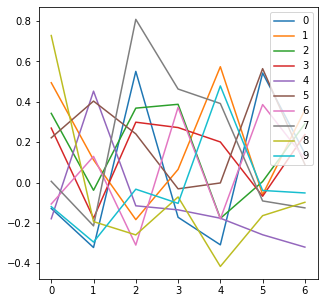

In [10]:
fig, ax = plt.subplots(figsize = (5.0, 5.0))
for i in range(10):
    ax.plot(z[i, 0:mm.y_dim].detach().to('cpu').numpy(), label = "%s" % i)
plt.legend()
plt.show()

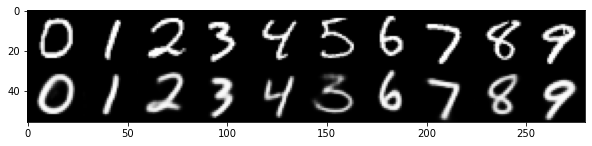

In [11]:
sample_data = []

sample_data.append(np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1))
sample_data.append(np.concatenate([recon[i,:,:] for i in range(10)], axis = 1))
sample_data = np.concatenate(sample_data, axis = 0)
fig = plt.figure(figsize=(10.0,10.0))
plt.imshow(sample_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.show()

# Sample Generation

## 1. Exemplar Generation

In [12]:
from XAE.sampler import gaus

exn = 5

In [13]:
zz = torch.cat((torch.zeros(1,mm.z_dim), gaus(exn,mm.z_dim)), dim = 0).to(device)
new_z = torch.cat((z[:,0:mm.y_dim].repeat_interleave(exn + 1, dim = 0).to(device), zz.repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

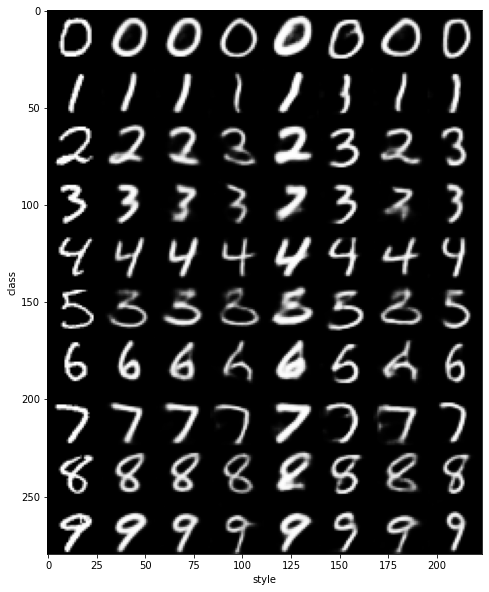

In [14]:
img_data = []
for i in range(10):
    img_data.append(np.concatenate([test_data[target[i]][0].numpy()[0,:,:]] + [recon[i,:,:]] + [new_x[(exn+1)*i + j] for j in range(exn+1)], axis = 1))
img_data = np.concatenate(img_data, axis = 0)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()

## 2. Style Transfer

In [15]:
new_z = torch.cat((z[:,:mm.y_dim].repeat_interleave(10, dim = 0), z[:,mm.y_dim:].repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

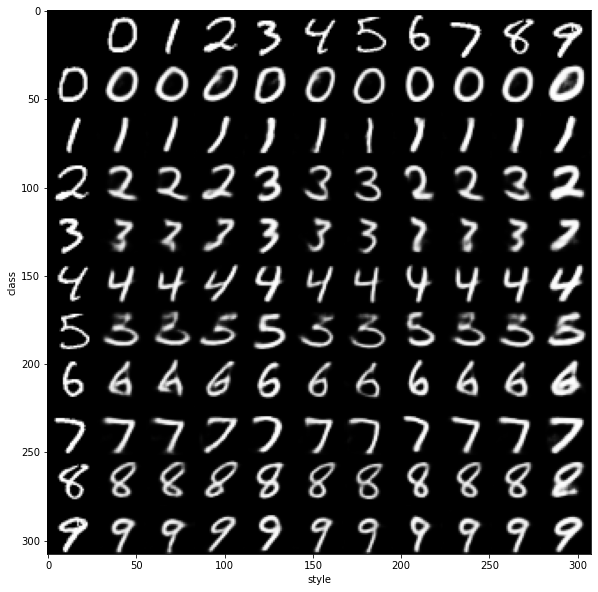

In [16]:
img_data = np.ones((28*11, 28*11))*-1
img_data[:28,28:] = np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1)
for i in range(10):
    img_data[((i+1)*28):((i+2)*28),:28] = test_data[target[i]][0].numpy()[0,:,:]
    img_data[((i+1)*28):((i+2)*28),28:] = np.concatenate(new_x[(10*i):(10*(i+1)),:,:], axis = 1)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()